In [1]:
import numpy as np
#import logit
from types import SimpleNamespace
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from copy import copy
plt.style.use('seaborn-whitegrid')

import pandas as pd
import datetime

import pandas_datareader # install with `pip install pandas-datareader`
import pydst # install with `pip install git+https://github.com/elben10/pydst`

from pandas_datareader import wb

# CO2 emissions

**Question 1:** Data cleaning. 
* Download data sets 1-3. Exclude all entries in the data sets that are not a country listed in country_region.xlsx. 
* Assign a world region to each country in data sets 1-3 using country_region.xlsx. 
* If a data-point in one data set is `NaN` for country $x$ in year $y$, then delete it together with the corresponding data-points for country $x$ in year $y$ in the 2 other data sets.

Check that the resulting number of rows for GDP, population and CO2 is 4786 in each case. 

In [2]:
# Load regions
regs = pd.read_excel('country_region.xlsx', header = 0)
regs.drop(['code'], inplace = True, axis = 1)
regions = regs.region.unique()

In [3]:
# Load population data
pop_name = 'SP.POP.TOTL'
pop_raw = wb.download(indicator=pop_name, country=[], start=1990, end=2016)
pop_raw = pop_raw.rename(columns = {pop_name:'POP'})
pop_raw = pop_raw.reset_index()

In [4]:
# Load GDP data
gdp_name = 'NY.GDP.MKTP.PP.KD'
gdp_raw = wb.download(indicator=gdp_name, country=[], start=1990, end=2016)
gdp_raw = gdp_raw.rename(columns = {gdp_name:'GDP'})
gdp_raw = gdp_raw.reset_index()

In [5]:
# Load CO2 data
co2_name = 'EN.ATM.CO2E.KT'
co2_raw = wb.download(indicator=co2_name, country=[], start=1990, end=2016)
co2_raw = co2_raw.reset_index()
co2_raw.rename(columns = {co2_name:'CO2'}, inplace=True) 

In [6]:
# Merge data sets to get a region for each country
data = pd.merge(co2_raw, gdp_raw, on=['year', 'country'], how='inner')
data = pd.merge(data, pop_raw, on=['year', 'country'], how='inner')
data = pd.merge(data, regs, on=['country'], how='inner')
data.sort_values(by=['region','country', 'year'], inplace = True)
data.reset_index(inplace = True, drop = True)

In [7]:
# Showing the data with added regions
display(data.head(5))
# Size of data set without cleaning
display(data.shape)

,country,year,CO2,GDP,POP,region
0,American Samoa,1990,NaN,NaN,47351.0,East Asia & Pacific
1,American Samoa,1991,NaN,NaN,48682.0,East Asia & Pacific
2,American Samoa,1992,NaN,NaN,49900.0,East Asia & Pacific
3,American Samoa,1993,NaN,NaN,51025.0,East Asia & Pacific
4,American Samoa,1994,NaN,NaN,52099.0,East Asia & Pacific


(5778, 6)

In [8]:
# Clean data by dropping rows containing NaNs
is_nan = (data.CO2.isna() | data.GDP.isna() | data.POP.isna())
data = data.loc[is_nan == False,:]
data.reset_index(inplace = True, drop = True)
data.to_csv('clean_data.csv', index = False, sep='\t', float_format='%d')

In [9]:
# Any NaNs left? 
print('All NaNs deleted?: ' + np.str(data.isna().sum() == 0))
print('Number of rows: ' + np.str(data.shape[0]))

All NaNs deleted?: country    True
year       True
CO2        True
GDP        True
POP        True
region     True
dtype: bool
Number of rows: 4660


**Question 2:** Regional CO2 emissions. Calculate the regional CO2 emissions per dollar GDP on an annual basis. That is, for region $R$ in year $t$ compute
$$
\frac{\sum_{j \in R} \text{CO2}_{j,t}}{\sum_{j \in R} Y_{j,t}}
$$
where $Y_{j}$ denotes the GDP of country $j$. 

Plot CO2 emissions per dollar GDP for all regions in the way you find most presentable and comment. 

In [10]:
# CO2 emissions pr mio. USD GDP (using mio. for nicer y-axis) for each region
data_reg = data.groupby(['region', 'year'])[['CO2', 'GDP', 'POP']].apply(sum)
data_reg['CO2_GDP'] = data_reg.CO2 / (data_reg.GDP/1e6)
data_reg.reset_index(inplace = True)

Kiloton C02 emissions pr mio. $GDP


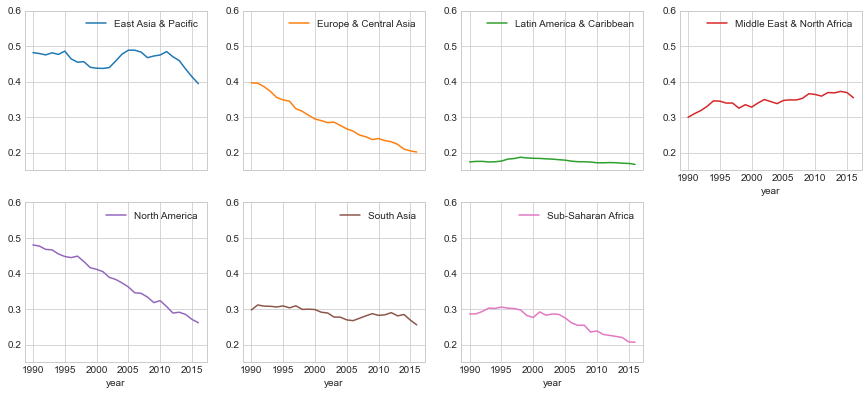

In [11]:
# Plot development in CO2/GDP by region
reg_co2 = data_reg.loc[:,['year', 'region', 'CO2_GDP']].copy()
reg_co2 = reg_co2.pivot(index=['year'], values='CO2_GDP', columns='region')
print('Kiloton C02 emissions pr mio. $GDP')
reg_co2.plot(subplots=True, figsize=(15, 10), layout=(3,4), ylim=(0.15,0.6));

**Question 3:** Growth rates. 
* For each region $R$, calculate population weighted average $\text{CO2}_{R,t}$  and GDP pr year. See weighted average definition below.
* Calculate the annual **growth rates** of averaged GDP and CO2 for each region.
* Finally, create **one subplot** per region containing the two associated growth rates. Make a brief comment. (*tip: better use a loop for this instead of code repetition*)

The weighted averages of of GDP and CO2 for region $R$ is obtained by first calculating the weights:
$$
w_{i,t} = \frac{POP_{i,t}}{\sum \limits_{k \in R}POP_{k,t}}
$$
for each country $i \in R$.   
Then get average regional GDP by
$$
\bar{Y}_{R,t} =  \sum \limits_{i \in R}w_{i,t}Y_{i,t}
$$
and similarly for CO2.

The growth rate for regional GDP per capita is then 
$$
\bar{Y}^{\Delta}_{R,t} = \frac{\bar{Y}_{R,t}}{\bar{Y}_{R,t-1}} - 1
$$
and similarly for regional CO2 pr capita

In [12]:
# Weights
df = data.copy()
df['w'] = df.groupby(['year', 'region'])['POP'].apply(lambda x: x/x.sum())

# Weighted CO2 and GDP measures
df['wGDP'] = df.w * df.GDP
df['wCO2'] = df.w * df.CO2
df_reg = df.groupby(['region', 'year'])[['wCO2', 'wGDP']].sum()
df_reg.reset_index(inplace = True)

# Calculate weighted growth rates in CO2 and GDP
df_reg['dCO2'] = df_reg.groupby(['region'])['wCO2'].apply(lambda x: x.pct_change(fill_method='ffill'))
df_reg['dGDP'] = df_reg.groupby(['region'])['wGDP'].apply(lambda x: x.pct_change(fill_method='ffill'))

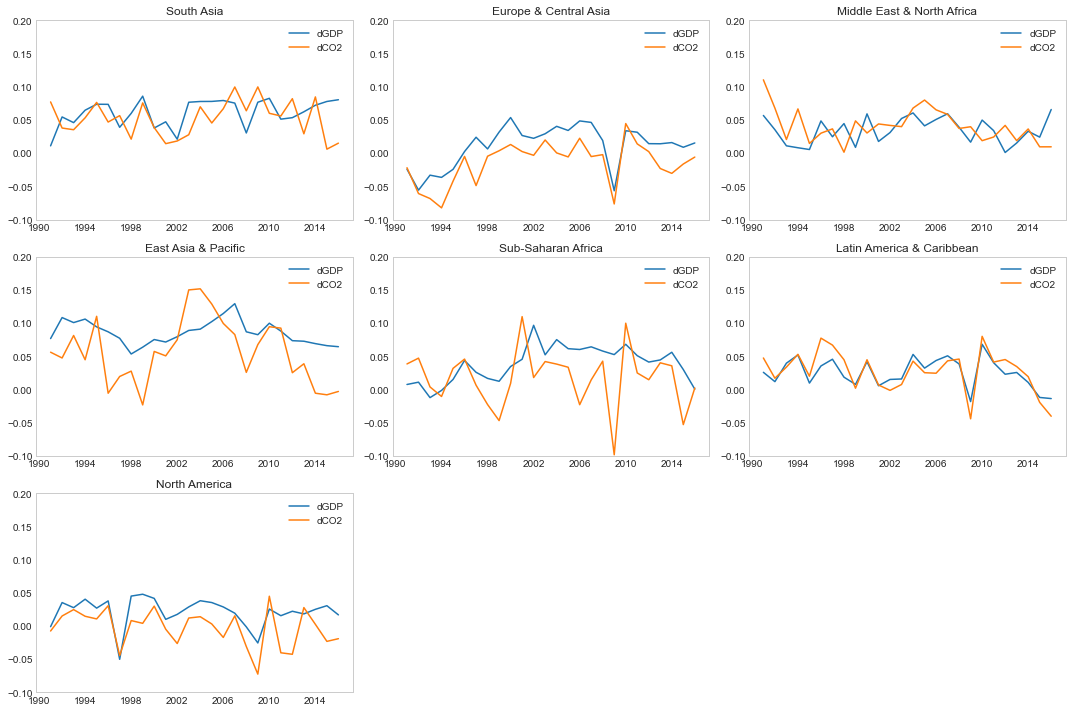

In [13]:
# Plotting the growth rates
nrow = 3
ncol = int(np.ceil(len(regions)/nrow))

# Loop over each region to create plot
fig = plt.figure(figsize=(15,10));
for i,reg in enumerate(regions):
    df_r = df_reg.loc[df_reg.region == reg, ['year', 'dCO2', 'dGDP']].copy()
    ax = plt.subplot(nrow, ncol, i+1)
    plt.plot(df_r.year, df_r.dGDP)
    plt.plot(df_r.year, df_r.dCO2)
    plt.legend(['dGDP', 'dCO2'])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
    plt.ylim(-0.1, .2)
    plt.title(reg)
    plt.grid(False)
    plt.tight_layout()

One observation is that severe economic downturns are reflected in CO2 emissions. For instance, the crisis of 2007-2009 shows up very clearly in several regions. In general, year-to-year changes in emissions track economic activity, though on varying scales. In the Western hemisphere, the two variables move together quite closely, whereas CO2 emissions fluctuate much more than GDP in Sub-Saharan Africa.  

# Risky assets

The consumption savings model with uncertainty in both income and interest rate.

A **household** lives two periods.

In the **second period** it gets utility from **consuming** and **leaving a bequest**,

$$
\begin{aligned}
v_{2}(m_{2})&= \max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho}+\nu\frac{(a_2+\kappa)^{1-\rho}}{1-\rho}\\
\text{s.t.} \\
a_2 &= m_2-c_2 \\
a_2 &\geq 0
\end{aligned}
$$

The **value function** $v_t(m_t)$ measures the household's value of having $m_t$ at the beginning of period $t$.

In the **first period**, the household gets utility from consuming and takes into account that it will also live in the next-period, where it receives a stochastic income.   

We assume that the consumption decision is made at the **beginning** of the period.   

We denote the interest rate on savings from period 1 to 2 by $r_{1,2}$. It is assumed to be **unknown** until the end of the period 1; ie. *after* the consumption decision is made.  

$$
\begin{aligned}
	v_1(m_1) &= \max_{c_1}\frac{c_{1}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{1}\left[v_2(m_2)\right]\\&\text{s.t.}&\\
	a_1 & = m_1-c_1\\
	m_2 &= (1+r_{1,2})a_1+y_2 \\
	r_{1,2} &= \begin{cases}
	r_0 - \Delta^r & \text{with prob. }\frac{1}{2}\\
	r_0 + \Delta^r & \text{with prob. }\frac{1}{2} \\
	\end{cases}\\
	y_{2} &= \begin{cases}
	1-\Delta^y & \text{with prob. }\frac{1}{2}\\
	1+\Delta^y & \text{with prob. }\frac{1}{2} 
	\end{cases}\\
	a_1 & \geq0
\end{aligned}
$$

In [14]:
# Parameters
rho = 8
kappa = 0.5
nu = 0.2
r0 = 0.3
Delta_r = 0.29
Delta_y = 0.5
beta = 0.98

**Question 1:** Solve the model for both periods and obtain value functions $v_1(m_1), v_2(m_2)$ together with the optimal consumption functions $c^*_1(m_1), c^*_2(m_2)$.   
Plot $v_1(m_1), v_2(m_2)$ in one graph and  $c^*_1(m_1), c^*_2(m_2)$ in another. 

In [15]:
import ConsumptionSavingReexam as CS

In [16]:
mp = SimpleNamespace()
mp.rho = rho
mp.kappa = kappa
mp.nu = nu
mp.r0 = r0
mp.beta = beta
mp.Delta_y = Delta_y
mp.y_prb_low = 0.5
mp.Delta_r = Delta_r
mp.n_r = 1

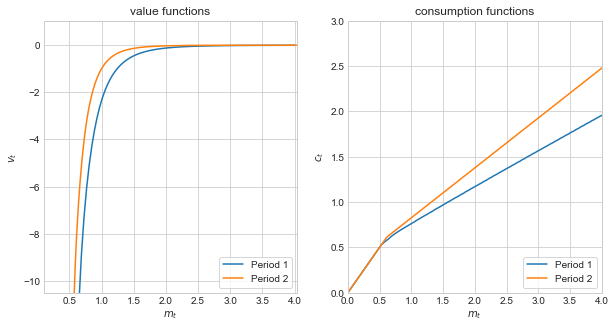

In [17]:
# a. Solving the model
model = CS.ConsumptionSavingModel(mp)
m1, c1, v1, m2, c2, v2 = model.solve()

# b. Plotting solution
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.plot(m1,v1, label=f'Period {1}')
ax.plot(m2,v2, label=f'Period {2}')
ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$m_t$')
ax.set_ylabel('$v_t$')
ax.set_title('value functions');
ax.set_xlim([0.1,4.04])
ax.set_ylim([-10.5,1.04]);

ax = fig.add_subplot(1,2,2)
ax.plot(m1,c1, label=f'Period {1}')
ax.plot(m2,c2, label=f'Period {2}')
ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$m_t$')
ax.set_ylabel('$c_t$')
ax.set_title('consumption functions');
ax.set_xlim([0,4.0])
ax.set_ylim([0,3.0]);

**Question 2:** Now set $\Delta^r = 0$ and solve the model once again. Plot the associated $c^*_1(m_1), c^*_2(m_2)$ and compare them with the consumption functions from the solution in Question 1.

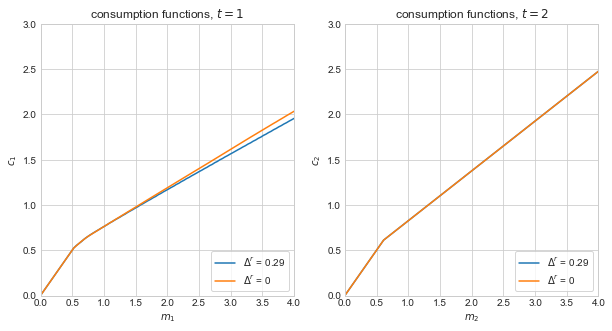

In [18]:
# a. Resolve model with no risk in r
mp_norisk = copy(mp)
mp_norisk.Delta_r = 0

model_norisk = CS.ConsumptionSavingModel(mp_norisk)
m1_norisk, c1_norisk, m2_norisk, _, c2_norisk, _ = model_norisk.solve()

# b. Plot comparison
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.plot(m1,c1, label=f'$\Delta^r$ = {mp.Delta_r}')
ax.plot(m1,c1_norisk, label=f'$\Delta^r$ = {mp_norisk.Delta_r}')
ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title(f'consumption functions, $t = 1$');
ax.set_xlim([0,4.0])
ax.set_ylim([0,3.0]);

ax = fig.add_subplot(1,2,2)
ax.plot(m2,c2, label=f'$\Delta^r$ = {mp.Delta_r}')
ax.plot(m2,c2_norisk, label=f'$\Delta^r$ = {mp_norisk.Delta_r}')
ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$m_2$')
ax.set_ylabel('$c_2$')
ax.set_title(f'consumption functions, $t = 2$');
ax.set_xlim([0,4.0])
ax.set_ylim([0,3.0]);

**Question 3 - option 1:** Simulate the period 2 choices of $N$ households both for the case where $\Delta^r=0.02$ and where $\Delta^r=0$.   
You can use the same distribution of $m_1$ for both cases as specified below.   
Plot the two distributions of $c_2$ and comment. 

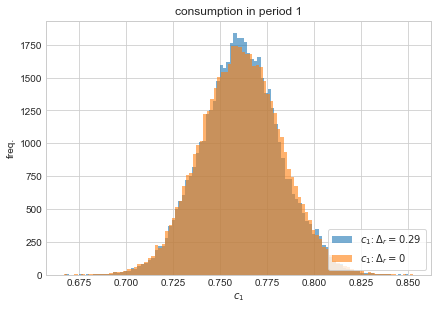

In [19]:
# a. Simulate from the two different models and plot
np.random.seed(2021)
simN = 50000
sim_m1 = np.fmax(np.random.normal(1, 0.05, size = simN), 0)

model.sim_m1 = copy(sim_m1)
c1_sim_risk, c2_sim_risk, m2_sim_risk  = model.simulate()

model_norisk.sim_m1 = copy(sim_m1)
c1_sim_norisk, c2_sim_norisk, m2_sim_norisk = model_norisk.simulate()

# b. Plot distribution of period 1 consumption
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist(c1_sim_risk,bins=100,label=f'$c_1$: $\Delta_r = {model.Delta_r}$', alpha = 0.6)
ax.hist(c1_sim_norisk,bins=100,label=f'$c_1$: $\Delta_r = {model_norisk.Delta_r}$', alpha = 0.6)
fig.tight_layout()

ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$c_1$')
ax.set_ylabel('freq.')
ax.set_title('consumption in period 1');

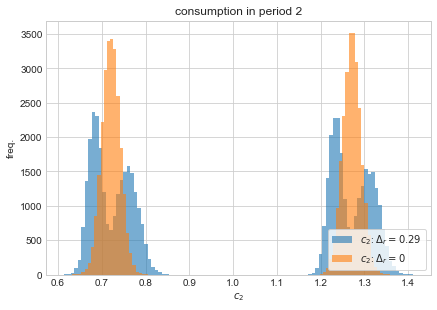

In [20]:
# c. Plot distribution of period 2 consumption
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist(c2_sim_risk,bins=100,label=f'$c_2$: $\Delta_r = {model.Delta_r}$', alpha = 0.6)
ax.hist(c2_sim_norisk,bins=100,label=f'$c_2$: $\Delta_r = {model_norisk.Delta_r}$', alpha = 0.6)
fig.tight_layout()
ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$c_2$')
ax.set_ylabel('freq.')
ax.set_title('consumption in period 2');

**Question 3 - option 2:** Generalizing the set of possible interest rate outcomes.   
We now consider the case where the interest rate has $N = 2n$ different possible realizations.   
Specifically, $r$ has $n$ possible outcomes higher than $r_0$, and $n$ outcomes lower than $r_0$, which are **uniformly** distributed:
$$
\begin{aligned}
	r &= \begin{cases}
	r_0 - n\Delta^r & \text{with prob. }\frac{1}{N}\\
	r_0 - (n-1)\Delta^r & \text{with prob. }\frac{1}{N}\\
	r_0 - (n-2)\Delta^r & \text{with prob. }\frac{1}{N}\\
    \vdots & \\
	r_0 - \Delta^r & \text{with prob. }\frac{1}{N}\\
	r_0 + \Delta^r & \text{with prob. }\frac{1}{N}\\
    \vdots & \\
	r_0 + (n-1)\Delta^r & \text{with prob. }\frac{1}{N} \\
	r_0 + n\Delta^r & \text{with prob. }\frac{1}{N} \\
	\end{cases}\\
\end{aligned}
$$

Implement this generalized specification in code.   
Test the model on the parameterization below and plot $c^*_1(m_1), c^*_2(m_2)$. 

In [21]:
# Initialize model with larger set of possible r outcomes. 
mp_r = copy(mp)
mp_r.n_r = 5
mp_r.Delta_r = 0.05
model_r = CS.ConsumptionSavingModel(mp_r)

Note: you can inspect `ConsumptionSavingModel.v1()` for the implementation together with the function `ConsumptionSavingModel.r_outcomes` for the generation of interest rate realizations

In [22]:
display(model_r.r_outcomes())

(array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.35, 0.4 , 0.45, 0.5 , 0.55]),
 array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]))

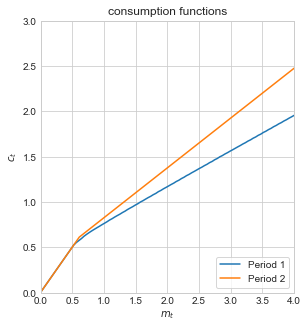

In [23]:
# a. Solve model with N outcomes of r
_, c1_r, _, _, c2_r, _ = model_r.solve()

# b. Plot comparison
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,2)
ax.plot(m1,c1, label=f'Period {1}')
ax.plot(m2,c2, label=f'Period {2}')
ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$m_t$')
ax.set_ylabel('$c_t$')
ax.set_title('consumption functions');
ax.set_xlim([0,4.0])
ax.set_ylim([0,3.0]);

# Interpolation

**Polynomial interpolation**   
Assume we have a set of data points $D = \{(y_i,x_i)\}_{i=1}^{n}$.  

We now want to create a polynomial $p$ of degree $n-1$ such that $y_i = p(x_i)$ *exactly* for all $x_i,y_i \in D$.

We can obtain such a polynomial $p$ by the following steps:
$$
\begin{align}
	p(x) & = \sum \limits_{i = 1}^{n} y_i \times l_i(x) \\
	l_i(x) & = \prod \limits_{j \ne i} \frac{x - x_j}{x_i - x_j}
\end{align}
$$

**Example**   
Say we have the function $f(x) = x^2 - 1$. We can then construct our set of data points $D$.   
To do so, we evaluate $f$ in the points $\{1, 3, 5\}$:  
* $f(1) = 0$
* $f(3) = 8$
* $f(5) = 24$

Thus we have $D = \{(0,1), (8,3), (24,5)\}$

Interpolating our function $f(x) = x^2 - 1$ at some $\hat{x} \in [1,5]$ is then given by

$$
p(\hat{x})  =  0 \times l_1(\hat{x}) + 3 \times l_2(\hat{x}) + 5 \times l_3 (\hat{x}) 
$$


$$
\begin{align}
	l_1(\hat{x}) = \frac{(\hat{x} - 3)}{(1 - 3)} \frac{(\hat{x} - 5)}{(1 - 5)}, \:\: 
    l_2(\hat{x}) = \frac{(\hat{x} - 1)}{(3 - 1)} \frac{(\hat{x} - 5)}{(3 - 5)}, \:\: 
    l_3(\hat{x}) = \frac{(\hat{x} - 1)}{(5 - 1)} \frac{(\hat{x} - 3)}{(5 - 3)}
\end{align}
$$

**Algorithm**   
First evaluate the function $f$ on the set of points $X$ so as to obtain the associated function values $Y$. Then follow the pseudo-code below.     

<img src="poly_algo_fig.png" style="width: 300px;"/> 

**Question 1:** Implement the algorithm to interpolate function values of $f$ to the point $\hat{x}$ 

In [24]:
def polynomial_interpol(x0, xs, ys):
    ''' Interpolate between the points (xs,ys) using a polynomial.
    
    Args:
    
    x0 (float): the point at which to interpolate.
    xs (ndarray): the set of points (x-coordinates) for which we interpolate exactly. 
    ys (ndarray): the set of y-coordinates that correspond to the x-coordinates xs.
    
    Returns
    px (float): the y-coordinate that corresponds to x0 given the interpolating polynomial.
    '''
    px = 0  
    n = len(xs)
    for i in range(n):
        # Create basis function i
        l_i = 1
        for j in range(n):
            if j == i:
                continue
            else:
                l_i *= (x0 - xs[j])/(xs[i] - xs[j])
        # Add basis function i in sum
        px += ys[i]*l_i
    
    return px

Testing the interpolation function:

In [25]:
f = lambda x: x**3

X1 = np.array([1, 2, 3, 4])
X2 = np.array([0.5, 3.2, 7, 12.9])

Y1 = f(X1)
Y2 = f(X2)

x = 3.22345 

y1_interpol = polynomial_interpol(x, X1, Y1)
print(f'f(x) = {f(x): .7f}  interpolated y = {y1_interpol: .7f}')

y2_interpol = polynomial_interpol(x, X2, Y2)
print(f'f(x) = {f(x): .7f}  interpolated y = {y2_interpol: .7f}')

f(x) =  33.4936760  interpolated y =  33.4936760
f(x) =  33.4936760  interpolated y =  33.4936760
